## Reposição de Ciência de Dados para Finanças

#### Aluno: Tales Nobre Leite Dias de Oliveira
#### Matrícula: 20200025983

##### Ativo Financeiro: Itaú Unibanco

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

In [2]:
# Definição da função Black-Scholes para calcular o prêmio da opção de compra (call)
def black_scholes_call(S, K, T, r, sigma):
    """
    Calcula o prêmio da opção de compra usando o modelo Black-Scholes.
    
    Parâmetros:
    S : preço do ativo subjacente
    K : preço de exercício da opção
    T : tempo até a expiração (em anos)
    r : taxa de juros livre de risco anualizada
    sigma : volatilidade anualizada do ativo subjacente
    
    Retorna:
    call_price : prêmio da opção de compra
    """
    # Calcula d1 e d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcula o prêmio da opção de compra
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# Definição da função Black-Scholes para calcular o prêmio da opção de venda (put)
def black_scholes_put(S, K, T, r, sigma):
    """
    Calcula o prêmio da opção de venda usando o modelo Black-Scholes.
    
    Parâmetros:
    S : preço do ativo subjacente
    K : preço de exercício da opção
    T : tempo até a expiração (em anos)
    r : taxa de juros livre de risco anualizada
    sigma : volatilidade anualizada do ativo subjacente
    
    Retorna:
    put_price : prêmio da opção de venda
    """
    # Calcula d1 e d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcula o prêmio da opção de venda
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return put_price

### Spread de Alta call
Uma estratégia de spread de alta tradicional visa um aumento moderado no preço do ativo subjacente, utilizando a compra de uma opção de compra com preço de exercício menor e a venda de outra com preço de exercício maior, ambas com mesma data de vencimento.

In [3]:
def inicializar_parametros_spread_alta(ticker, r, n_desejado):

    acao = yf.Ticker(ticker)
    historico = acao.history(period="1y")['Close']

    S0 = historico.iloc[-n_desejado]

    # Calcular a volatilidade histórica
    log_returns = np.log(historico / historico.shift(1))
    volatilidade_historica = log_returns.std() * np.sqrt(252)

    K1 = S0 * 1.0222  # 2.22% acima do preço atual
    K2 = S0 * 1.0444  # 4.44% acima do preço atual

    # Calcular T(vencimento), que é o tempo até a expiração em anos para o número desejado de passos
    T = n_desejado / 252

    # Calcular prêmios de opções usando Black-Scholes
    premio1 = black_scholes_call(S0, K1, T, r, volatilidade_historica)
    premio2 = black_scholes_call(S0, K2, T, r, volatilidade_historica)
    
    parametros = {
        'S0': S0,
        'K1': K1,
        'K2': K2,
        'serie_historica': historico[-n_desejado:].values.tolist(),
        'Taxa de juros': r,
        'n': n_desejado,
        'Volatilidade': volatilidade_historica,
        'Tempo até a expiração': T,
        'premio1': premio1,
        'premio2': premio2
    }

    return parametros


parametros = inicializar_parametros_spread_alta('ITUB', r = 11.25/100, n_desejado = 30)

In [4]:
def criar_arvore_binomial_spread_alta(parametros):
    
    S0 = parametros['S0']  # Preço inicial do ativo
    K1 = parametros['K1']  # Preço de exercício da opção de compra (call) inferior
    K2 = parametros['K2']  # Preço de exercício da opção de compra (call) superior
    r = parametros['Taxa de juros']  # Taxa de juros livre de risco anualizada
    serie_historica = parametros['serie_historica']
    sigma = parametros['Volatilidade']  # Volatilidade anualizada
    T = parametros['Tempo até a expiração']  # Tempo até a expiração em anos
    n = parametros['n']  # Número de passos na árvore binomial
    premio1 = parametros['premio1']  # Prêmio da opção de compra (call) inferior
    premio2 = parametros['premio2']  # Prêmio da opção de compra (call) superior

    dt = T / n

    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Probabilidade de alta (p - probabilidade neutra ao risco)
    p = (np.exp(r * dt) - d) / (u - d)

    # Probabilidade de baixa (1 - p)
    q = 1 - p

    # Construindo a árvore de preços do ativo subjacente
    precos_arvore = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            precos_arvore[j, i] = S0 * (u ** j) * (d ** (i - j))


    # Ajustando a lógica para o cálculo do desembolso com base nos prêmios das opções
    desembolso_total = premio2 - premio1  # Prêmio líquido recebido inicialmente
    resultado_final = desembolso_total  # Inicializa com o prêmio líquido

    for preco_ativo in serie_historica[1:]:
        if preco_ativo <= K1:
            # Se o preço está abaixo de K1, as opções não têm valor intrínseco
            desembolso = desembolso_total  # Nenhum valor adicional além do prêmio líquido
        elif K1 < preco_ativo <= K2:
            # Se o preço está entre K1 e K2, somente a opção de K1 tem valor intrínseco
            call1 = max(preco_ativo - K1, 0)
            desembolso = call1 + desembolso_total
        else:
            # Se o preço está acima de K2, ambas as opções têm valor intrínseco
            call1 = -premio1 + max(preco_ativo - K1, 0)
            call2 = -premio2 + max(preco_ativo - K2, 0)
            desembolso = (call1 - call2)
        resultado_final += desembolso  # Acumula o desembolso

    tabela_parametros = pd.DataFrame({
        "Δt (Variação Temporal)": [dt],
        "u (Fator de Movimento de Alta)": [u],
        "d (Fator de Movimento de Baixa)": [d],
        "p (Probabilidade de Alta)": [p],
        "1 - p (Probabilidade de Baixa)": [q],
        "Payoff Total": [resultado_final]  # Atualizado para mostrar o desembolso total
    })

    return precos_arvore, tabela_parametros

precos_arvore, tabela_parametros = criar_arvore_binomial_spread_alta(parametros)

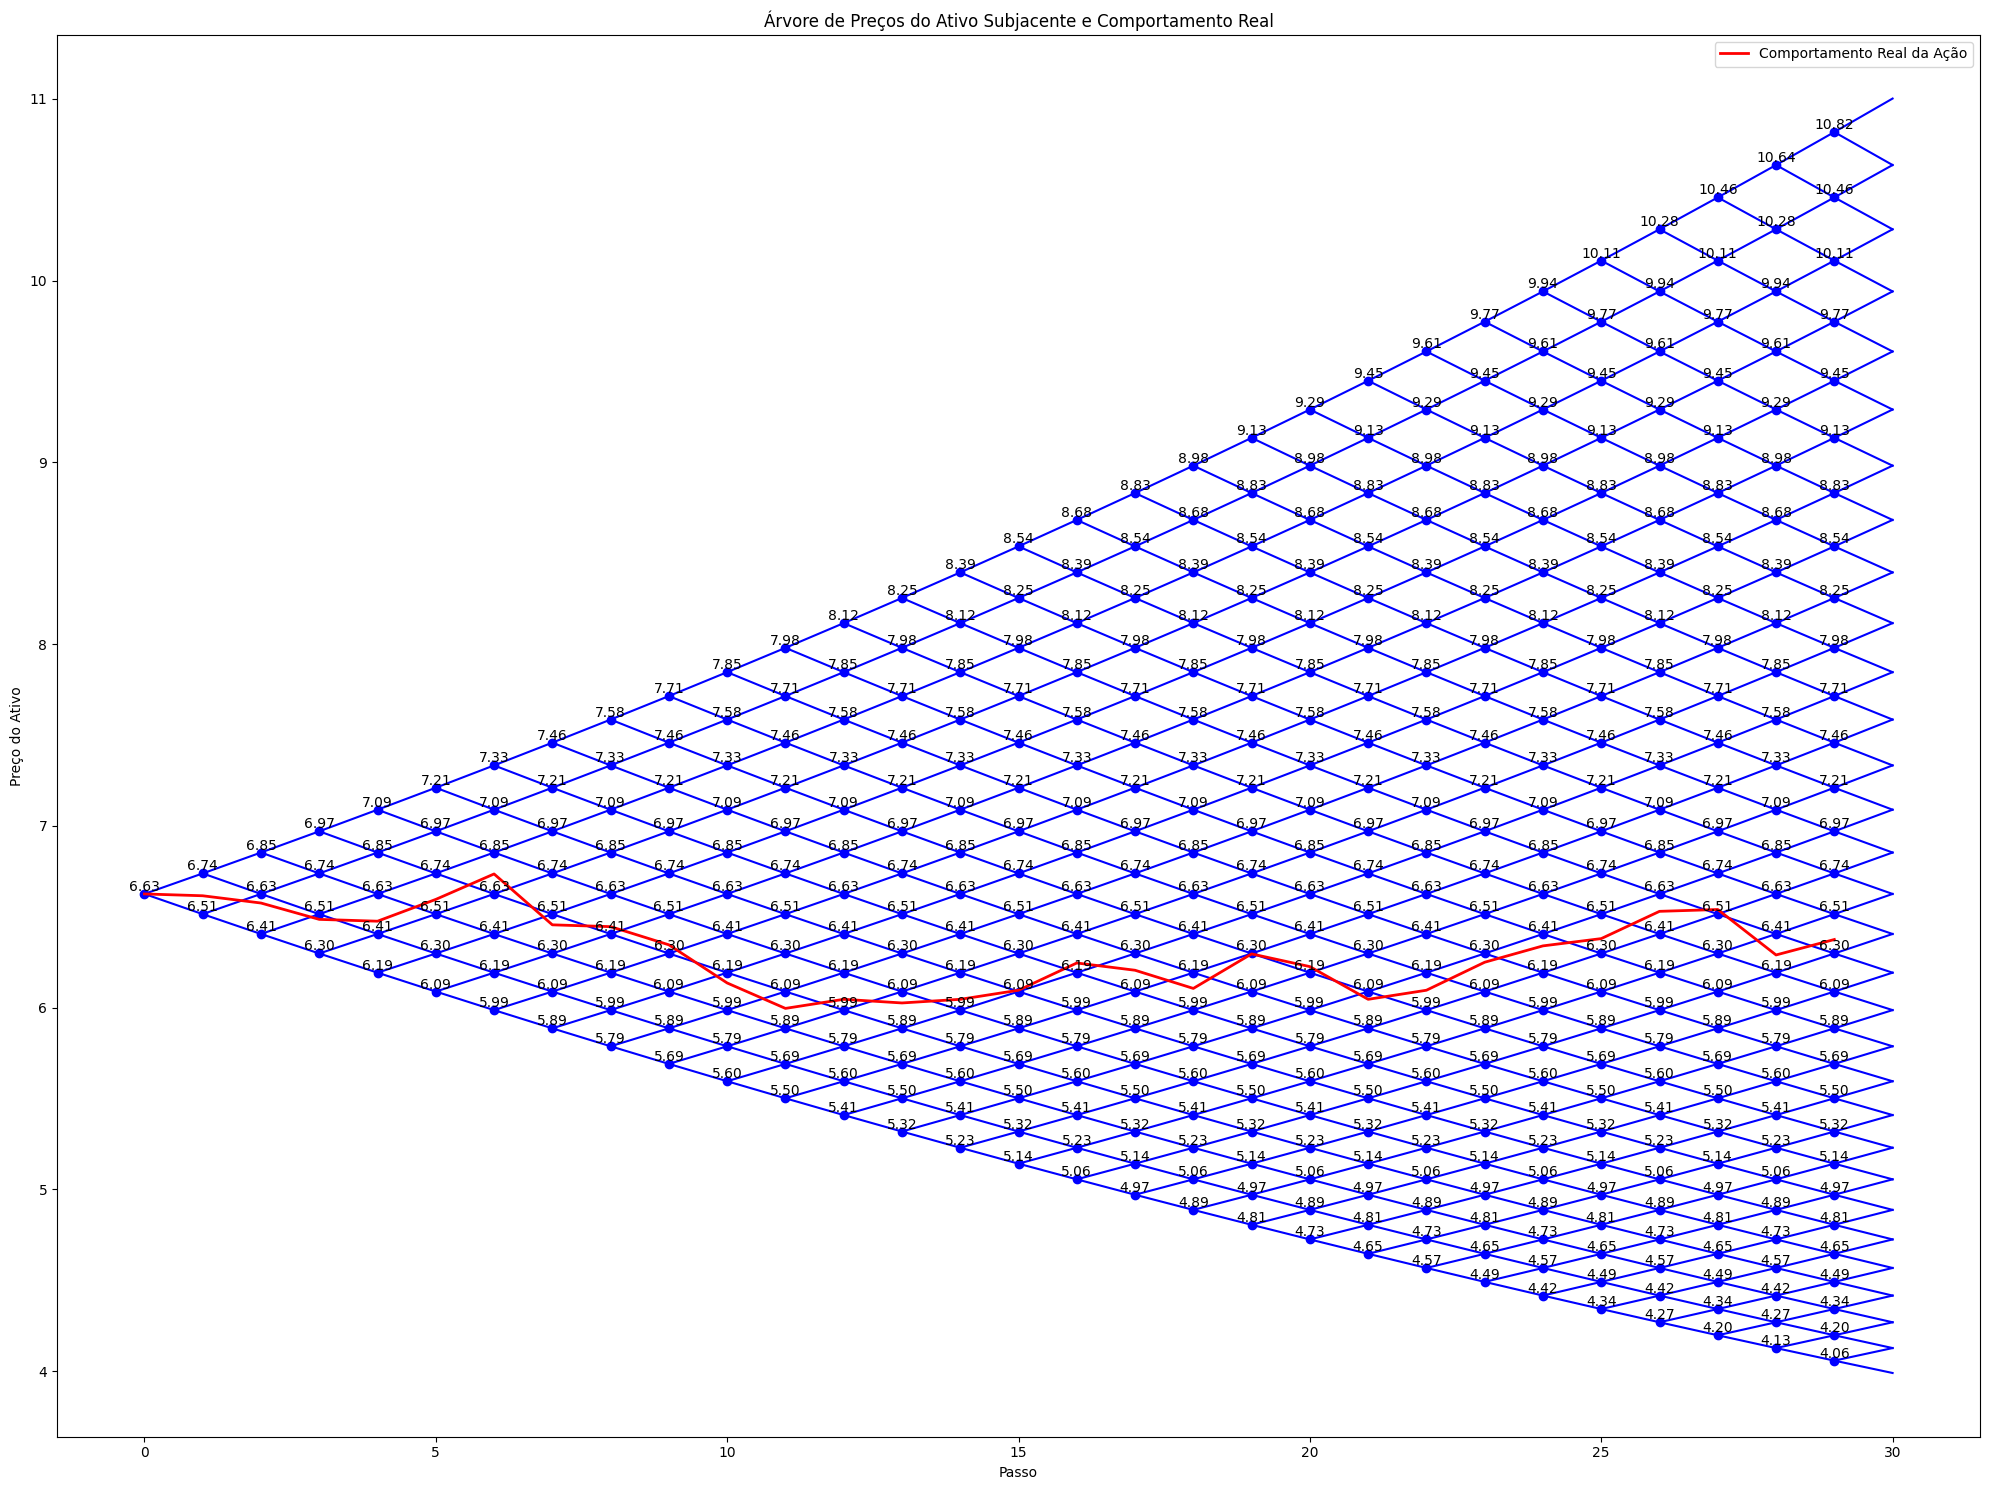

In [5]:
def plot_arvore_precos(precos_arvore, n, historico_precos):
    plt.figure(figsize=(20, 15))
    for i in range(n):
        for j in range(i+1):
            if i < n:
                plt.plot([i, i+1], [precos_arvore[j, i], precos_arvore[j, i+1]], 'b-')
                plt.plot([i, i+1], [precos_arvore[j, i], precos_arvore[j+1, i+1]], 'b-')
            plt.plot(i, precos_arvore[j, i], 'bo')
            plt.text(i, precos_arvore[j, i], f'{precos_arvore[j, i]:.2f}', ha='center', va='bottom')

    plt.plot(range(n), historico_precos[:n], 'r-', linewidth=2, label='Comportamento Real da Ação')
    
    plt.title('Árvore de Preços do Ativo Subjacente e Comportamento Real')
    plt.xlabel('Passo')
    plt.ylabel('Preço do Ativo')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_arvore_precos(precos_arvore, n=parametros['n'], historico_precos=parametros['serie_historica'])

In [6]:
def executar_simulacao(ativos, codigos, r, n, funcao_inicializar, funcao_arvore_binomial):
    
    codigo_para_nome = dict(zip(codigos, ativos))
    parametros_dfs = []
    tabelas_parametros = []

    for codigo in codigos:
        parametros = funcao_inicializar(codigo, r=r, n_desejado=n)
        parametros_df = pd.DataFrame([parametros])
        parametros_df['Ativo'] = codigo_para_nome[codigo]
        parametros_dfs.append(parametros_df)
        
        _, tabela_parametros = funcao_arvore_binomial(parametros)
        tabela_parametros['Ativo'] = codigo_para_nome[codigo]
        tabelas_parametros.append(tabela_parametros)

    parametros_df = pd.concat(parametros_dfs, ignore_index=True)
    parametros_df.drop('serie_historica', axis=1, inplace=True)

    tabela_parametros_arvore_df = pd.concat(tabelas_parametros, ignore_index=True)

    return parametros_df, tabela_parametros_arvore_df

In [7]:
n = 30  # 30 dias de simulação
r = 11.25 / 100  # Taxa de juros anual

ativo = ['Itaú Unibanco']
codigo = ['ITUB']

parametros_df, tabela_parametros_arvore_df = executar_simulacao(ativo, codigo, r, n, inicializar_parametros_spread_alta, criar_arvore_binomial_spread_alta)

In [8]:
parametros_df

,S0,K1,K2,Taxa de juros,n,Volatilidade,Tempo até a expiração,premio1,premio2,Ativo
0,6.625653,6.772742,6.919832,0.1125,30,0.268291,0.119048,0.218204,0.160227,Itaú Unibanco


In [9]:
tabela_parametros_arvore_df

,Δt (Variação Temporal),u (Fator de Movimento de Alta),d (Fator de Movimento de Baixa),p (Probabilidade de Alta),1 - p (Probabilidade de Baixa),Payoff Total,Ativo
0,0.003968,1.017044,0.983241,0.508985,0.491015,-1.739321,Itaú Unibanco


### Spread de Baixa call
O spread de baixa lucra com a queda do preço do ativo subjacente, combinando opções do mesmo tipo sobre o mesmo ativo, mas com diferentes preços de exercício ou datas de vencimento.

In [10]:
def inicializar_parametros_spread_baixa(ticker, r, n_desejado):

    # Obter o histórico de preços de fechamento
    acao = yf.Ticker(ticker)
    historico = acao.history(period=f"{1}y")['Close']

    # Obter o preço inicial
    S0 = historico.iloc[-n_desejado]

    # Calcular a volatilidade histórica
    log_returns = np.log(historico / historico.shift(1))
    volatilidade_historica = log_returns.std() * np.sqrt(252)

    K2 = S0 * 0.9778 # 2.22% abaixo do preço atual
    K1 = S0 * 0.9556 # 4.44% abaixo do preço atual

    # Calcular T(vencimento), que é o tempo até a expiração em anos para o número desejado de passos
    T = n_desejado / 252

    # Calcular prêmios de opções usando Black-Scholes
    premio1 = black_scholes_call(S0, K1, T, r, volatilidade_historica)
    premio2 = black_scholes_call(S0, K2, T, r, volatilidade_historica)

    parametros = {
        'S0': S0,
        'K1': K1,
        'K2': K2,
        'serie_historica': historico[-n_desejado:].values.tolist(),
        'Taxa de juros': r,
        'n': n_desejado,
        'Volatilidade': volatilidade_historica,
        'Tempo até a expiração': T,
        'premio1': premio1,
        'premio2': premio2
    }
    
    return parametros

parametros = inicializar_parametros_spread_baixa('ITUB', r = 11.25/100, n_desejado = 30)


In [11]:
def criar_arvore_binomial_spread_baixa(parametros):

    S0 = parametros['S0']  # Preço inicial do ativo
    K1 = parametros['K1']  # Preço de exercício da opção de compra (call) inferior
    K2 = parametros['K2']  # Preço de exercício da opção de compra (call) superior
    r = parametros['Taxa de juros']  # Taxa de juros livre de risco anualizada
    serie_historica = parametros['serie_historica']
    sigma = parametros['Volatilidade']  # Volatilidade anualizada
    T = parametros['Tempo até a expiração']  # Tempo até a expiração em anos
    n = parametros['n']  # Número de passos na árvore binomial
    premio1 = parametros['premio1']  # Prêmio da opção de compra (call) inferior
    premio2 = parametros['premio2']  # Prêmio da opção de compra (call) superior

    dt = T / n

    # Fator de movimento de alta (u) e baixa (d)
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Probabilidade neutra ao risco (p)
    p = (np.exp(r * dt) - d) / (u - d)

    # Probabilidade de baixa (1 - p)
    q = 1 - p
    
    # Construindo a árvore de preços do ativo subjacente
    precos_arvore = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            precos_arvore[j, i] = S0 * (u ** j) * (d ** (i - j))


    desembolso_total = premio1 - premio2  # Prêmio líquido recebido inicialmente
    resultado_final = desembolso_total  # Inicializa com o prêmio líquido

    for preco_ativo in serie_historica[1:]:
        if preco_ativo <= K1:
            # Se o preço está abaixo de K1, as opções não têm valor intrínseco
            desembolso = desembolso_total
        elif K1 < preco_ativo <= K2:
            # Se o preço está entre K1 e K2, somente a opção de K1 tem valor intrínseco
            call1 = max(preco_ativo - K1, 0)
            desembolso = -call1 + desembolso_total
        else:
            # Se o preço está acima de K2, ambas as opções têm valor intrínseco
            call1 = -premio1 + max(preco_ativo - K1, 0)
            call2 = -premio2 + max(preco_ativo - K2, 0)
            desembolso = (call2 - call1)
        resultado_final += desembolso


        tabela_parametros = pd.DataFrame({
            "Δt (Variação Temporal)": [dt],
            "u (Fator de Movimento de Alta)": [u],
            "d (Fator de Movimento de Baixa)": [d],
            "p (Probabilidade de Alta)": [p],
            "1 - p (Probabilidade de Baixa)": [q],
            "Payoff Total": [resultado_final]  # Atualizado para mostrar o desembolso total
        })

    return precos_arvore, tabela_parametros

precos_arvore, tabela_parametros = criar_arvore_binomial_spread_baixa(parametros)

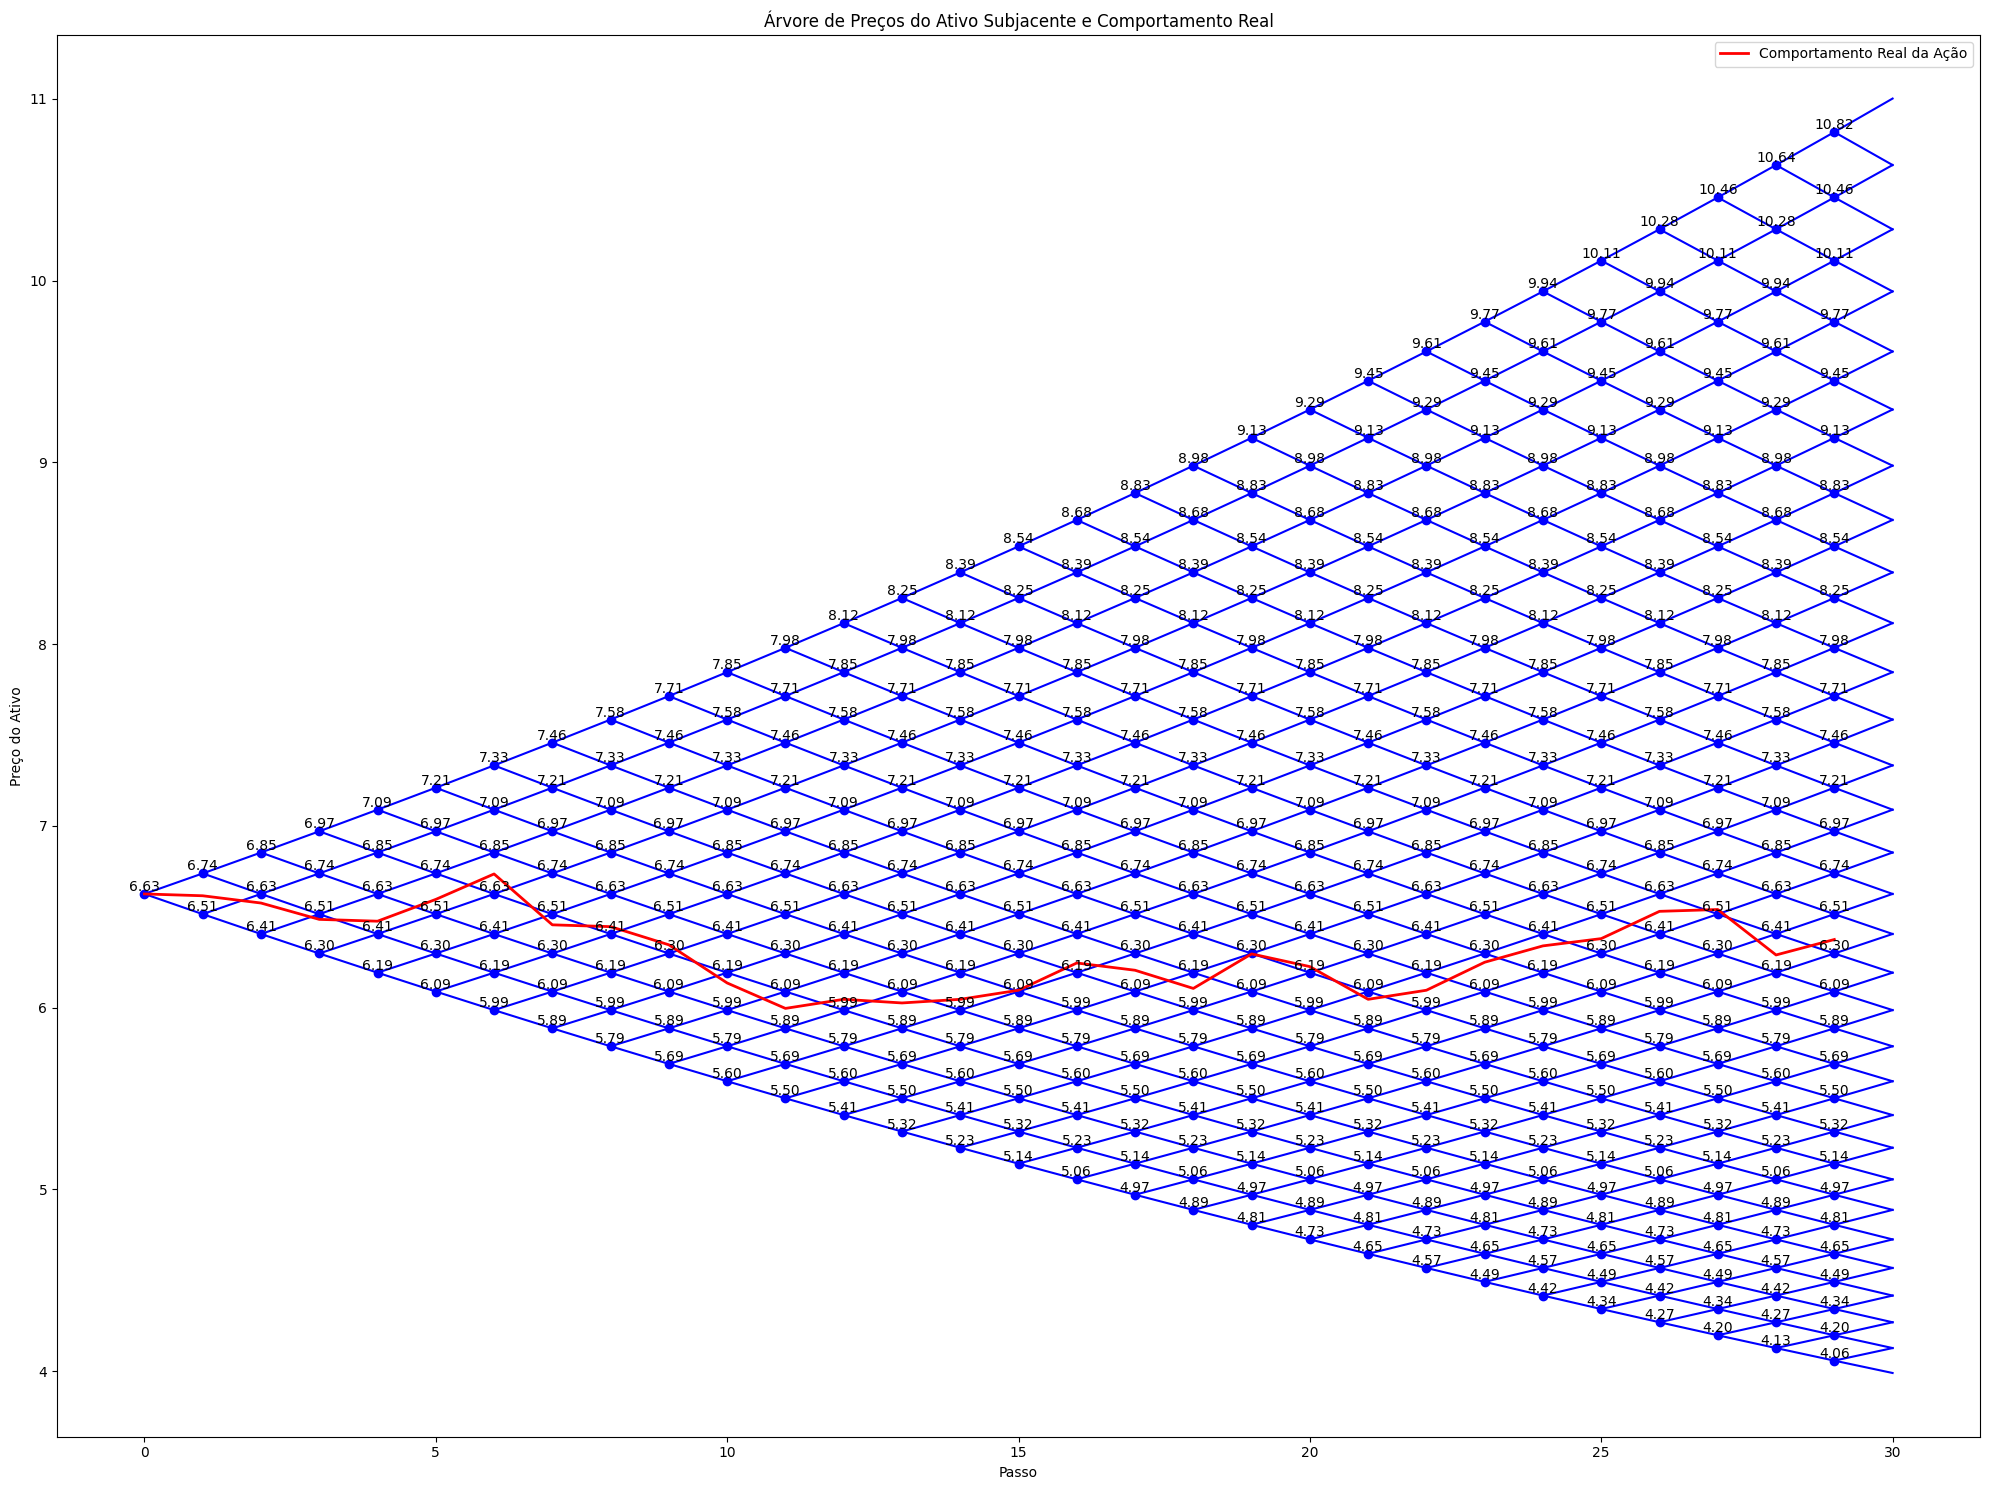

In [12]:
plot_arvore_precos(precos_arvore, n=parametros['n'], historico_precos=parametros['serie_historica'])

In [13]:
n = 30  # 30 dias de simulação  
r = 11.25 / 100  # Taxa de juros anual

ativo = ['Itaú Unibanco']
codigo = ['ITUB']

parametros_df, tabela_parametros_arvore_df = executar_simulacao(ativo, codigo, r, n, inicializar_parametros_spread_alta, criar_arvore_binomial_spread_alta)


In [14]:
parametros_df

,S0,K1,K2,Taxa de juros,n,Volatilidade,Tempo até a expiração,premio1,premio2,Ativo
0,6.625653,6.772742,6.919832,0.1125,30,0.268291,0.119048,0.218204,0.160227,Itaú Unibanco


In [15]:
tabela_parametros_arvore_df

,Δt (Variação Temporal),u (Fator de Movimento de Alta),d (Fator de Movimento de Baixa),p (Probabilidade de Alta),1 - p (Probabilidade de Baixa),Payoff Total,Ativo
0,0.003968,1.017044,0.983241,0.508985,0.491015,-1.739321,Itaú Unibanco


### Butterfly Spread call

O Butterfly Spread é uma estratégia de opções que combina três preços de exercício diferentes, mas com o mesmo vencimento. Ela pode usar opções de compra ou venda e visa lucrar com a estabilidade do preço do ativo subjacente, quando a volatilidade é esperada para ser baixa.

In [16]:
def inicializar_parametros_butterfly_spread(ticker, r, n_desejado):
    
    # Obter o histórico de preços de fechamento
    acao = yf.Ticker(ticker)
    historico = acao.history(period=f"{1}y")['Close'] 
    
    S0 = historico.iloc[-n_desejado]
    
    # Calcular a volatilidade histórica
    log_returns = np.log(historico / historico.shift(1))
    volatilidade_historica = log_returns.std() * np.sqrt(252)
    
    # Definir os preços de exercício para K1, K2 e K3
    K1 = S0 * 0.95 # 5% abaixo do preço atual
    K2 = S0  # K2 é normalmente o preço atual ou próximo dele
    K3 = S0 * 1.05 # 5% acima do preço atual
    
    # Calcular T (vencimento), que é o tempo até a expiração em anos para o número desejado de passos
    T = n_desejado / 252

    # Calcular prêmios das opções usando Black-Scholes
    premio_K1_call = black_scholes_call(S0, K1, T, r, volatilidade_historica)
    premio_K2_call = black_scholes_call(S0, K2, T, r, volatilidade_historica)
    premio_K3_call = black_scholes_call(S0, K3, T, r, volatilidade_historica)
    
    parametros = {
        'S0': S0,
        'K1': K1,
        'K2': K2,
        'K3': K3,
        'serie_historica': historico[-n_desejado:].values.tolist(),
        'Taxa de juros': r,
        'n': n_desejado,
        'Volatilidade': volatilidade_historica,
        'Tempo até a expiração': T,
        'premio1': premio_K1_call,
        'premio2': premio_K2_call,
        'premio3': premio_K3_call
    }
    
    return parametros


parametros = inicializar_parametros_butterfly_spread('ITUB', r = 11.25/100, n_desejado = 30)


In [17]:
def LLopcao(Tipo, Transacao, Premio, X, S):
    if Tipo == 'call' and Transacao == 'compra':
        return -Premio + max(0, S - X)
    elif Tipo == 'call' and Transacao == 'venda':
        return Premio - max(0, S - X)
    elif Tipo == 'put' and Transacao == 'compra':
        return -Premio + max(0, X - S)
    elif Tipo == 'put' and Transacao == 'venda':
        return Premio - max(0, X - S)

In [18]:
def criar_arvore_binomial_butterfly_spread(parametros):
    
    # Desempacotando os parâmetros
    S0 = parametros['S0']  # Preço inicial do ativo
    K1 = parametros['K1']
    K2 = parametros['K2']  
    K3 = parametros['K3']  
    r = parametros['Taxa de juros']  # Taxa de juros livre de risco anualizada
    serie_historica = parametros['serie_historica']
    sigma = parametros['Volatilidade']  # Volatilidade anualizada
    T = parametros['Tempo até a expiração']  # Tempo até a expiração em anos
    n = parametros['n']  # Número de passos na árvore binomial
    premio1 = parametros['premio1']  
    premio2 = parametros['premio2']  
    premio3 = parametros['premio3']  
    
    # Calcular Δt, u, d e p
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)
    
    
    # Construir a árvore de preços
    precos_arvore = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            precos_arvore[j, i] = S0 * (u ** j) * (d ** (i - j))
    
    
    # Ajustar a lógica para o cálculo do desembolso com base nos prêmios das opções
    desembolso_total = premio1 - 2* premio2 + premio3  # Prêmio líquido recebido inicialmente
    resultado_final = desembolso_total  # Inicializa com o prêmio líquido

    for preco_ativo in serie_historica[1:]:
        # Calcula o LL para cada opção no spread butterfly
        call1 = LLopcao('call', 'compra', premio1, K1, preco_ativo)
        call2 = LLopcao('call', 'venda', premio2, K2, preco_ativo)
        call3 = LLopcao('call', 'compra', premio3, K3, preco_ativo)

        # Calcula o desembolso total considerando o desembolso efetivo inicial
        desembolso = (call1 + 2 * call2 + call3) + desembolso_total
        resultado_final += desembolso

    # Criando tabela com pandas
    tabela_parametros = pd.DataFrame({
            "Δt (Variação Temporal)": [dt],
            "u (Fator de Movimento de Alta)": [u],
            "d (Fator de Movimento de Baixa)": [d],
            "p (Probabilidade de Alta)": [p],
            "1 - p (Probabilidade de Baixa)": [1 - p],
            "Payoff Total": [resultado_final]  # Atualizado para mostrar o desembolso total
        })
    
    return precos_arvore, tabela_parametros

precos_arvore, tabela_parametros = criar_arvore_binomial_butterfly_spread(parametros)


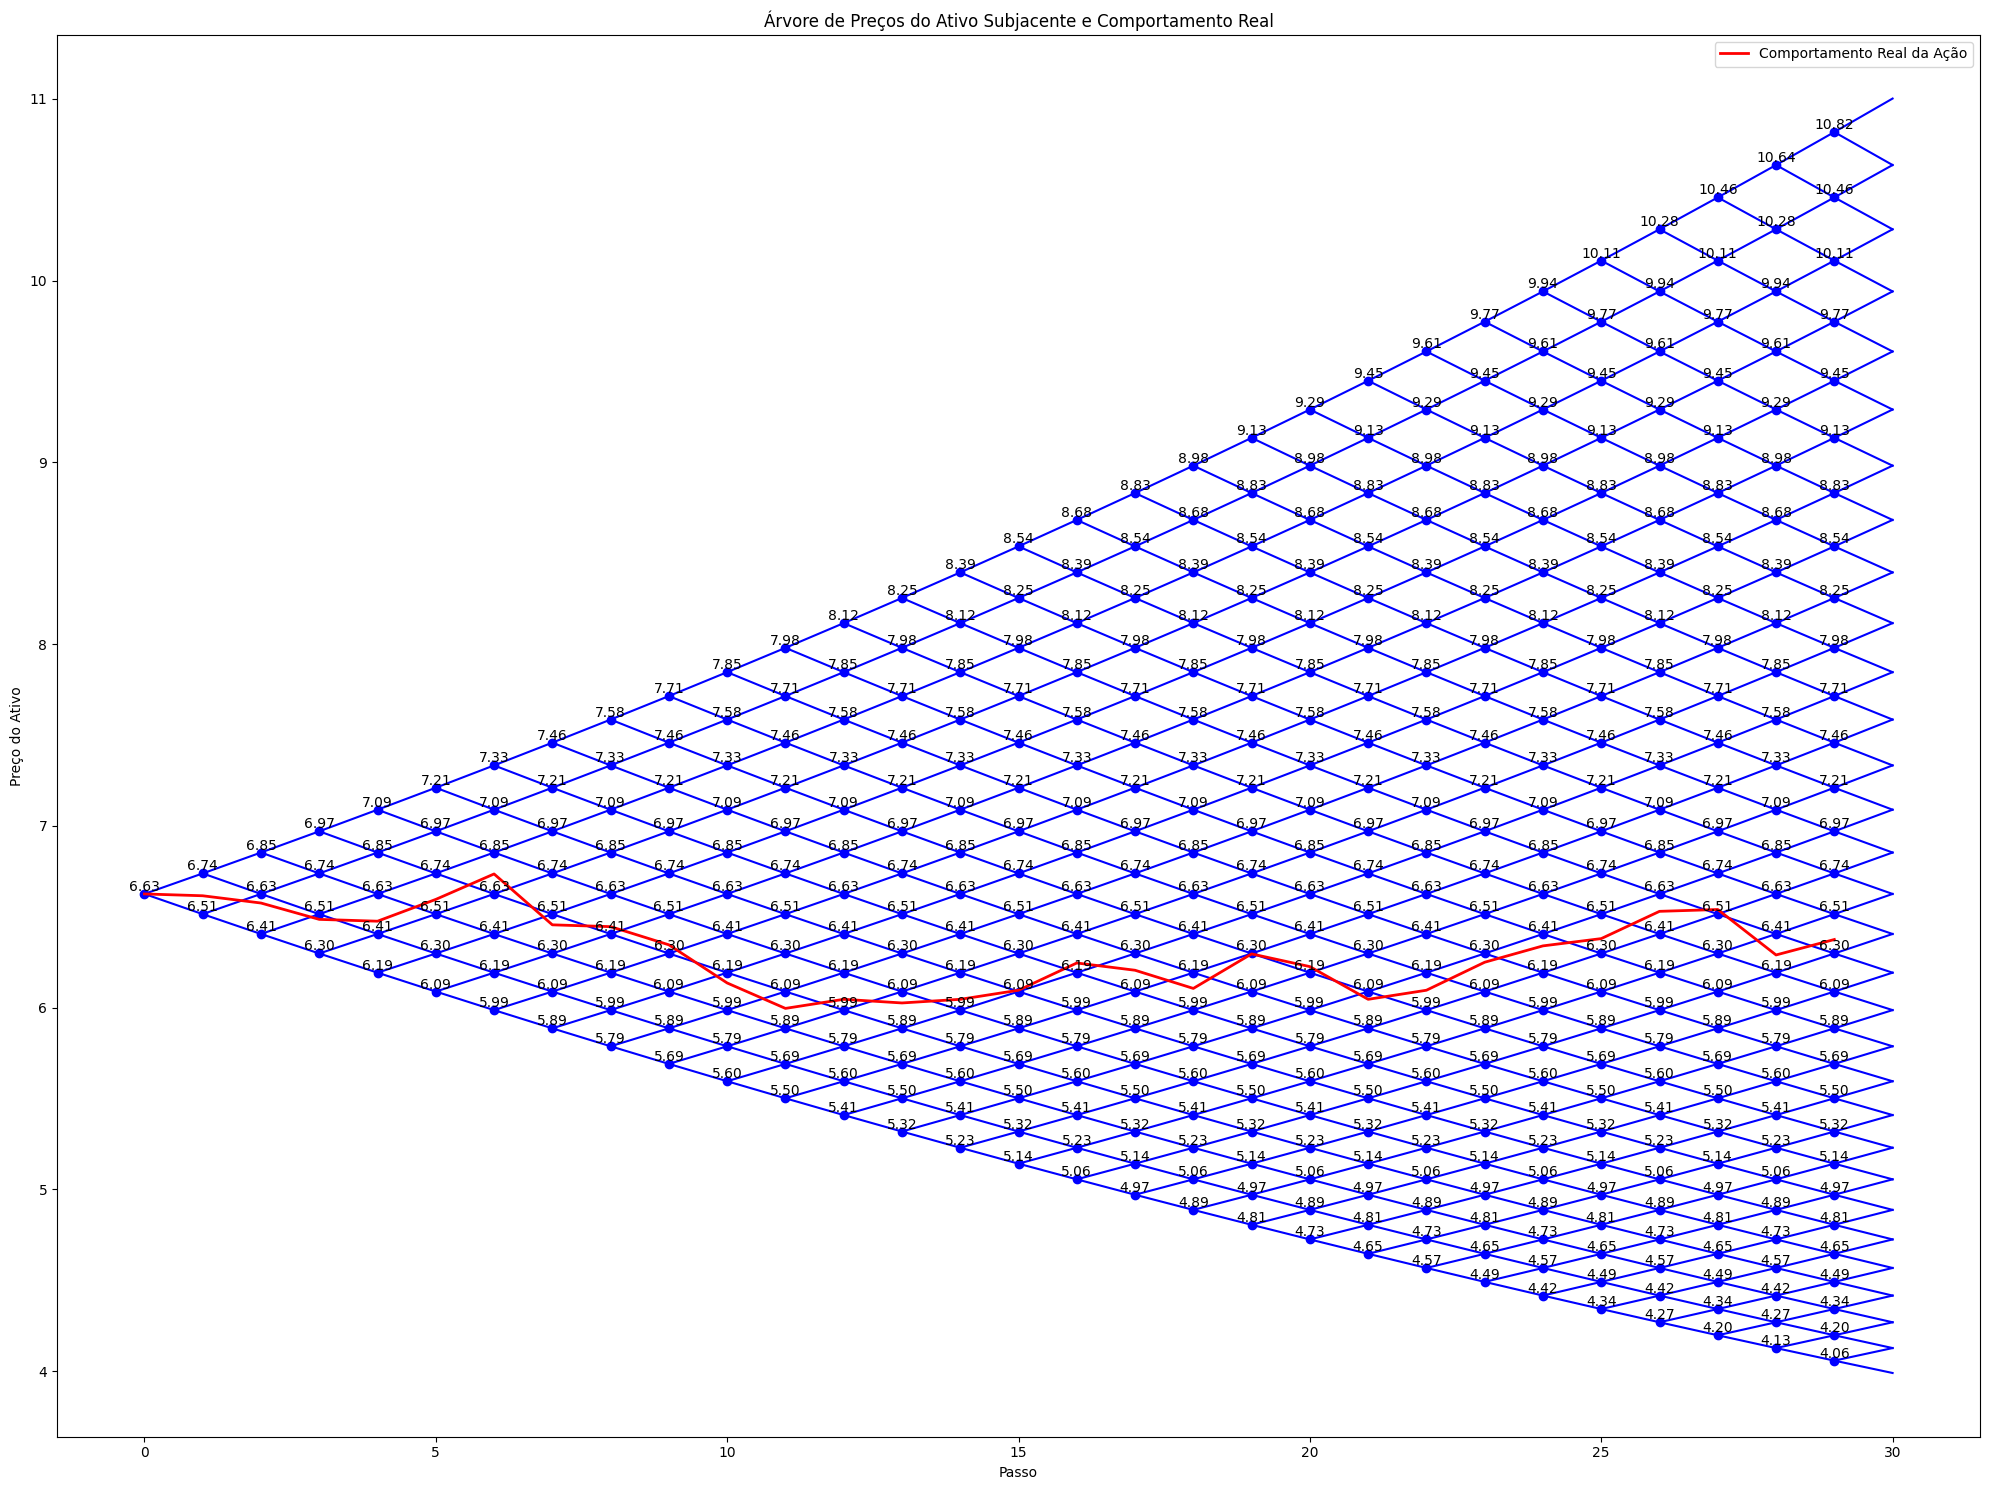

In [19]:
plot_arvore_precos(precos_arvore, n=parametros['n'], historico_precos=parametros['serie_historica'])

In [20]:
n = 30  # 30 dias de simulação
r = 11.25 / 100  # Taxa de juros anual

ativo = ['Itaú Unibanco']
codigo = ['ITUB']

parametros_df, tabela_parametros_arvore_df = executar_simulacao(ativo, codigo, r, n, inicializar_parametros_spread_alta, criar_arvore_binomial_spread_alta)


In [21]:
parametros_df

,S0,K1,K2,Taxa de juros,n,Volatilidade,Tempo até a expiração,premio1,premio2,Ativo
0,6.625653,6.772742,6.919832,0.1125,30,0.268291,0.119048,0.218204,0.160227,Itaú Unibanco


In [22]:
tabela_parametros_arvore_df

,Δt (Variação Temporal),u (Fator de Movimento de Alta),d (Fator de Movimento de Baixa),p (Probabilidade de Alta),1 - p (Probabilidade de Baixa),Payoff Total,Ativo
0,0.003968,1.017044,0.983241,0.508985,0.491015,-1.739321,Itaú Unibanco
